In [83]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys

from sklearn.linear_model import SGDClassifier, LinearRegression, Lasso, Ridge
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
import seaborn as sn
import random
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.manifold import TSNE
import tqdm
import copy
from sklearn.svm import LinearSVC 

from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import TruncatedSVD
import torch
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

import sklearn
from sklearn.linear_model import LogisticRegression
import random
import pickle
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import neural_network
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
def set_seeds(seed):
    
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    
    
def load_glove():
    with open("glove_data/data.pickle", "rb") as f:
        data_dict = pickle.load(f)
        X,y,words_train = data_dict["train"]
        X_dev, y_dev, words_dev = data_dict["dev"]
        X_test, y_test, words_test = data_dict["test"]
        X,y = X[y > -1], y[y>-1]
        X_dev,y_dev = X_dev[y_dev > -1], y_dev[y_dev>-1]
        X_test, y_test = X_test[y_test > -1], y_test[y_test > -1]
        return (X,y, words_train), (X_dev, y_dev, words_dev), (X_test, y_test, words_test)
    
    
def perform_purity_test(vecs, k, labels_true):
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        score = sklearn.metrics.homogeneity_score(labels_true, labels_pred)
        return score

def compute_v_measure(vecs, labels_true, k=2):
    
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        return sklearn.metrics.v_measure_score(labels_true, labels_pred)
    
    
def load_word_vectors(fname):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False, limit = 150000)
    vecs = model.vectors
    words = list(model.vocab.keys())
    return model, vecs, words

def save_in_word2vec_format(vecs: np.ndarray, words: np.ndarray, fname: str):


    with open(fname, "w", encoding = "utf-8") as f:

        f.write(str(len(vecs)) + " " + "300" + "\n")
        for i, (v,w) in tqdm.tqdm_notebook(enumerate(zip(vecs, words))):

            vec_as_str = " ".join(["{:.6f}".format(x) for x in v])
            f.write(w + " " + vec_as_str + "\n")
            
            
def get_inlp_p(ws, rank):
    ws_normed = ws/np.linalg.norm(ws, axis = 1, keepdims = True)
    ws_normed = ws_normed[:rank]
    P = np.eye(ws.shape[1]) - ws_normed.T@ws_normed
    return P

def get_relaxed_p(rank2adv, rank):
    
    adv = rank2adv[rank]
    U,D = get_svd(adv)
    U = U.T
    W = U[-rank:] 
    P = np.eye(X.shape[1]) - W.T@W 
    return P

def get_v_measure(X,Y,P,num_clusts=2):
    X_proj, Y = X@P, Y
    
    #before = compute_v_measure(X[:], Y[:], k = num_clusts)
    after = compute_v_measure(X_proj[:], Y[:], k=num_clusts) 
          
    return after


def bolukbasi_debiasing(directions, input_dim, rank):
    """
    the goal of this function is to perform INLP on a set of user-provided directiosn (instead of learning those directions).
    :param directions: list of vectors, as numpy arrays.
    :param input_dim: dimensionality of the vectors.
    """
    import scipy
    if np.allclose(directions, 0):
        w_basis = np.zeros_like(directions.T)
    else:
        w_basis = scipy.linalg.orth(directions.T) # orthogonal basis

    svd = sklearn.decomposition.TruncatedSVD(n_components=rank)
    if rank < len(directions):
        w_basis = svd.inverse_transform(svd.fit_transform(w_basis.T))
        w_basis = w_basis / np.linalg.norm(w_basis, axis=1, keepdims=True)
        w_basis = w_basis.T

    P = np.eye(input_dim) - w_basis@w_basis.T

    return P


In [85]:
(X,y, words_train), (X_dev, y_dev, words_dev), (X_test, y_test, words_test) = load_glove()

In [86]:
model_all, vecs_all, words_all =  load_word_vectors(fname = "glove_data/glove.42B.300d.txt")

In [87]:
projs_rlace = {}
projs_inlp = {}

for seed in range(5):
    
    with open("interim/rlace/run={}/Ps_rlace.pickle".format(seed), "rb") as f:
        projs_rlace[seed] = pickle.load(f)[0]
    
    with open("interim/inlp/run={}/Ps_inlp.pickle".format(seed), "rb") as f:
        projs_inlp[seed] = pickle.load(f)[0]
        
specific_words = [["woman", "man"], ["girl", "boy"], ["she", "he"], ["mother", "father"], ["daughter", "son"], ["gal", "guy"], ["female", "male"], ["her", "his"], ["herself", "himself"], ["mary", "john"]]
vecs_specific_words = np.array([ [model_all[p[1]] - model_all[p[0]]] for p in specific_words])
vecs_specific_words = vecs_specific_words.squeeze(1)
projs_words = []
for i in range(1,11):
    P = bolukbasi_debiasing(vecs_specific_words.copy(), 300, rank=i)
    projs_words.append(P)


In [88]:
with open("interim/rlace/run=1/Ps_rlace.pickle".format(seed), "rb") as f:
    data = pickle.load(f)
    
data[1]

{1: 0.5066666666666667,
 2: 0.5077551020408163,
 4: 0.50421768707483,
 8: 0.506938775510204,
 12: 0.506938775510204,
 16: 0.5048979591836734,
 20: 0.5046258503401361}

In [89]:
def plot_pca(X,y, path, title, method = "pca"):
    import matplotlib.pyplot as plt
    plt.rcParams['font.family'] = 'Sans'

    if method == "pca":
        pca = PCA(n_components=2)
        M=6000
    elif method == "tsne":
        pca = TSNE(n_components=2, learning_rate="auto", init="pca")
        M=2000
        
    X_proj = pca.fit_transform(X[:M])
    ax = plt.axes()
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.xaxis.grid(color='gray', linestyle='dashed')
    
    y_text = ["Female-biased" if yy==1 else "Male-biased" for yy in y]
    plt1 = sn.scatterplot(X_proj[:, 0], X_proj[:, 1], hue = y_text[:M])
    plt.legend(fontsize=19)
    ax.set_title('{}'.format(title), fontsize=25)
    ax.figure.savefig("{}/{}.pdf".format(path, title), dpi = 400)
    plt.show()
    plt.clf()
    
def get_maj(Y):
    
    from collections import Counter
    c = Counter(Y)
    p,q = list(c.values())
    return max(p/(p+q), 1 - p/(p+q))


/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


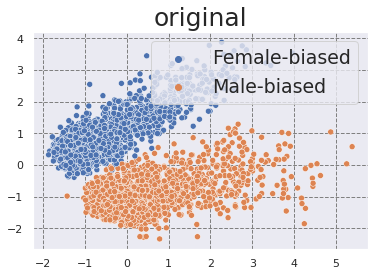

<Figure size 432x288 with 0 Axes>

In [90]:
plot_pca(X_dev, y_dev, path="analysis/analysis-results",title = "original")

/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


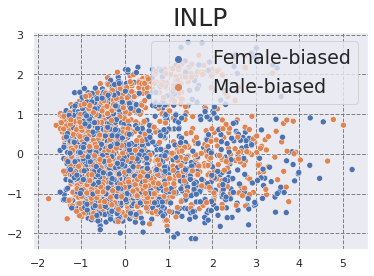

<Figure size 432x288 with 0 Axes>

In [91]:
plot_pca(X_dev@projs_inlp[0][1], y_dev, path="analysis/analysis-results",title = "INLP")

/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


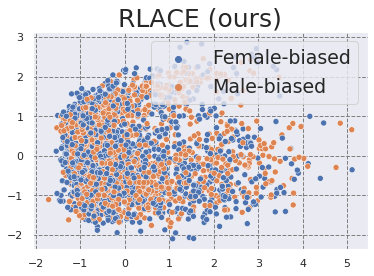

<Figure size 432x288 with 0 Axes>

In [92]:
plot_pca(X_dev@projs_rlace[0][1], y_dev, path="analysis/analysis-results",title = "RLACE (ours)")

In [93]:
#plot_pca(X_dev@projs_words[2], y_dev, path=None,title = "PCA-based debiasing")

In [94]:
# import matplotlib.pyplot as plt
# plt.rcParams['font.family'] = 'Sans'

# accs_inlp = np.array([projs_inlp[i]["accs"] for i in projs_inlp.keys()])
# accs_rel = np.array([projs_rlace[i]["accs"] for i in projs_inlp.keys()])

# accs_inlp_df = pd.DataFrame(accs_inlp, columns = range(len(projs_inlp[0]["accs"])))
# accs_rel_df = pd.DataFrame(accs_rel, columns = [0]+projs_rlace[0]["ranks"])

# accs_inlp = accs_inlp.mean(axis=0)
# accs_rel = accs_rel.mean(axis=0)

# ranks = projs_rlace[0]["ranks"]
# ranks = [0] + ranks

# ax = sn.lineplot(range(16), accs_inlp[:16], marker="o", label = "INLP")
# sn.lineplot(ranks, accs_rel, label="RLACE (ours)", marker = "o", color = "red")
# ax.axhline(get_maj(y), label="Majority", color = "black", linestyle="--")
# sn.set(font_scale=1)
# ax.set(ylabel="Accuracy Post-Projection", xlabel="Dimensions Removed", ylim=[0,1.03])
# plt.xticks(range(0,21,2), fontsize=16)
# plt.yticks(fontsize=20)

# plt.xlabel("Dimensions Removed", fontsize=20)
# plt.ylabel("Accuracy Post-Projection", fontsize=20)

# plt.subplots_adjust(bottom=0.18)
# plt.subplots_adjust(left=0.18)
# ax.legend(fontsize=15)
# ax.figure.savefig("relaxed_vs_inlp_{}.pdf".format("glove"), dpi = 400)    

In [95]:
# accs_rel_df

In [147]:

v_measures_rlace = defaultdict(dict)
v_measures_inlp = defaultdict(dict)
v_measures_pca = defaultdict(dict)
v_measures_original = defaultdict(dict)

number_of_clusts = [2,3,5,10,15,20,30]

NUM_CLUSTERS=5

for num_clust in number_of_clusts:
    set_seeds(0)
    after = get_v_measure(X_dev, y_dev, np.eye(300), num_clusts=num_clust)
    v_measures_original[1][num_clust] = after
    print("Original {}: {}".format(num_clust, after))

for num_clust in number_of_clusts:
        set_seeds(0)
        after = get_v_measure(X_dev, y_dev, projs_words[0], num_clusts=num_clust)
        v_measures_pca[1][num_clust] = after
        print("pca", num_clust, after)
        
        
print("Starting")
rank = 1
for rand_seed in projs_rlace.keys():
    
    set_seeds(0)
    Ps_rlace = projs_rlace[rand_seed]
    Ps_inlp = projs_inlp[rand_seed]
    
    P_rlace = Ps_rlace[rank]
    P_inlp = Ps_inlp[rank-1]
    
    for num_clust in number_of_clusts:

        after = get_v_measure(X_dev, y_dev, P_rlace, num_clusts=num_clust)
        v_measures_rlace[rand_seed][num_clust] = after
        print(num_clust, after)
    print("-------------")
    
    #for num_clusts in number_of_clusts:
    for num_clust in number_of_clusts:
        set_seeds(0)
        after = get_v_measure(X_dev, y_dev, P_inlp, num_clusts=num_clust)
        v_measures_inlp[rand_seed][num_clust] = after
        print(num_clust, after)
        
    print("-------------")
    

        
    print("==========================")
        

Original 2: 1.0
Original 3: 0.6778304418036202
Original 5: 0.6321732227062642
Original 10: 0.45781218541489044
Original 15: 0.38969314341437383
Original 20: 0.3656262343542788
Original 30: 0.33277933587229375
pca 2 0.005169876892059316
pca 3 0.008843825146290845
pca 5 0.013525908504735385
pca 10 0.30127794010735554
pca 15 0.25069248722814674
pca 20 0.26315635156160483
pca 30 0.27055942441845
Starting
2 5.5354631229660656e-05
3 0.00037905066629563105
5 0.03586216148073483
10 0.07369829513154451
15 0.10654785147777956
20 0.11748296468127274
30 0.1089437326328201
-------------
2 0.0012751659333405175
3 0.0011013075648533765
5 0.0619715413385864
10 0.12817636827930912
15 0.12234756768209662
20 0.14284760974657137
30 0.13502077547759936
-------------
2 7.695006110047016e-05
3 0.0004182032666343437
5 0.05336971873022601
10 0.07572290171654525
15 0.09255854272649536
20 0.11354575812991977
30 0.11081369170892007
-------------
2 0.0012264177477130161
3 0.0014788382095883837
5 0.0715596842482845

In [148]:
v_measures_inlp_df = pd.DataFrame(v_measures_inlp)
v_measures_inlp_df['average'] = v_measures_inlp_df.mean(numeric_only=True, axis=1)
v_measures_inlp_df["std"] = v_measures_inlp_df.std(numeric_only=True, axis=1)
v_measures_inlp_df = v_measures_inlp_df.rename_axis("num_clusters").reset_index()


v_measures_rlace_df = pd.DataFrame(v_measures_rlace)
v_measures_rlace_df['average'] = v_measures_rlace_df.mean(numeric_only=True, axis=1)
v_measures_rlace_df["std"] = v_measures_rlace_df.std(numeric_only=True, axis=1)
v_measures_rlace_df = v_measures_rlace_df.rename_axis("num_clusters").reset_index()

v_measures_pca_df = pd.DataFrame(v_measures_pca)
v_measures_pca_df['average'] = v_measures_pca_df.mean(numeric_only=True, axis=1)
v_measures_pca_df["std"] = v_measures_pca_df.std(numeric_only=True, axis=1)
v_measures_pca_df = v_measures_pca_df.rename_axis("num_clusters").reset_index()


v_measures_original_df = pd.DataFrame(v_measures_original)
v_measures_original_df['average'] = v_measures_original_df.mean(numeric_only=True, axis=1)
v_measures_original_df["std"] = v_measures_original_df.std(numeric_only=True, axis=1)
v_measures_original_df = v_measures_original_df.rename_axis("num_clusters").reset_index()

In [149]:
v_measures_inlp_df.to_csv("analysis/analysis-results/v_measure_inlp.csv")
v_measures_rlace_df.to_csv("analysis/analysis-results/v_measure_rlace.csv")
v_measures_pca_df.to_csv("analysis/analysis-results/v_mesure_pca.csv")
v_measures_original_df.to_csv("analysis/analysis-results/v_mesure_original.csv")

In [150]:
v_measures_rlace_df

,num_clusters,0,1,2,3,4,average,std
0,2,0.000055,0.000077,0.000055,0.000077,0.000037,0.000060,0.000015
1,3,0.000379,0.000418,0.000358,0.000478,0.000486,0.000424,0.000052
2,5,0.035862,0.053370,0.034723,0.052226,0.024418,0.040120,0.011099
3,10,0.073698,0.075723,0.106162,0.083821,0.074813,0.082844,0.012195
4,15,0.106548,0.092559,0.108190,0.135297,0.133331,0.115185,0.016548
5,20,0.117483,0.113546,0.102652,0.111148,0.113213,0.111608,0.004925
6,30,0.108944,0.110814,0.110447,0.112520,0.111035,0.110752,0.001147


In [151]:
v_measures_original_df

,num_clusters,1,average,std
0,2,1.000000,1.000000,0.0
1,3,0.677830,0.677830,0.0
2,5,0.632173,0.632173,0.0
3,10,0.457812,0.457812,0.0
4,15,0.389693,0.389693,0.0
5,20,0.365626,0.365626,0.0
6,30,0.332779,0.332779,0.0


In [152]:
v_measures_inlp_df

,num_clusters,0,1,2,3,4,average,std
0,2,0.001275,0.001226,0.001185,0.001275,0.001181,0.001228,0.000041
1,3,0.001101,0.001479,0.001615,0.001428,0.000952,0.001315,0.000248
2,5,0.061972,0.071560,0.117578,0.108963,0.078454,0.087705,0.021692
3,10,0.128176,0.168543,0.180747,0.126303,0.135109,0.147776,0.022468
4,15,0.122348,0.171492,0.153115,0.137044,0.137547,0.144309,0.016717
5,20,0.142848,0.148476,0.159841,0.137347,0.141335,0.145969,0.007801
6,30,0.135021,0.149210,0.148256,0.130642,0.145783,0.141782,0.007522


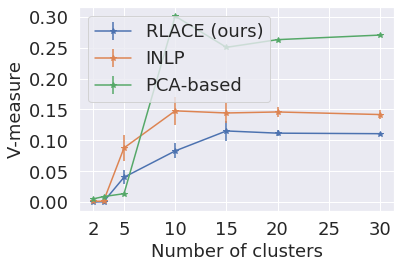

In [153]:
sn.set()

fig, ax = plt.subplots()
plt.rcParams['font.family'] = 'Sans'

v_measures_rlace_df.plot('num_clusters', 'average', yerr='std', ax=ax, label="RLACE (ours)", marker="*")
v_measures_inlp_df.plot('num_clusters', 'average', yerr='std', ax=ax, label="INLP", marker="*")
v_measures_pca_df.plot('num_clusters', 'average', yerr='std', ax=ax, label="PCA-based", marker="*")
#v_measures_original_df.plot('num_clusters', 'average', yerr='std', ax=ax, label="Original space", marker="*", linestyle = "--")

plt.ylabel("V-measure", fontsize=18)
plt.xlabel("Number of clusters", fontsize=18)

plt.legend(fontsize=18)
#ax.yaxis.grid(color='gray', linestyle="-")
#ax.xaxis.grid(color='gray', linestyle='-')
plt.yticks(fontsize=18)
plt.xticks([2,5,10,15,20,25,30], fontsize=18)
plt.subplots_adjust(bottom=0.17)
plt.subplots_adjust(left=0.17)
ax.figure.savefig("analysis/analysis-results/v-mesaure.pdf", dpi = 400)    
plt.show()


## classification

In [103]:


accs_inlp = defaultdict(dict)
accs_rlace = defaultdict(dict)
accs_pca = defaultdict(dict)

model_class = SGDClassifier
model_params = {"max_iter": 150000, "tol": 1e-4, "n_iter_no_change": 50, "alpha": 0.5*1e-4}

for rand_seed in projs_rlace.keys():
    print(rand_seed)
    
    set_seeds(0)
    Ps_rlace = projs_rlace[rand_seed]
    Ps_inlp = projs_inlp[rand_seed]
    
    for i,rank in enumerate(projs_rlace[rand_seed].keys()):
        
        P = projs_rlace[rand_seed][rank]
        
        clf = model_class(**model_params)
        X_train_clean, X_test_clean = X@P, X_test@P
        clf.fit(X_train_clean, y)
        score = clf.score(X_test_clean, y_test)
        accs_rlace[rand_seed][rank] = score
        print("rlace", rank, score)
        
        P = (projs_inlp[rand_seed][rank-1])
        #mlp = sklearn.neural_network.MLPClassifier()
        clf = model_class(**model_params)
        X_train_clean, X_test_clean = X@P, X_test@P
        clf.fit(X_train_clean, y)
        score = clf.score(X_test_clean, y_test)
        accs_inlp[rand_seed][rank] = score
        print("inlp", rank, score)
        
    print("==========================")
    
         
    
        

0
rlace 1 0.5246666666666666
inlp 1 0.862
rlace 2 0.5255555555555556
inlp 2 0.7617777777777778
rlace 4 0.5177777777777778
inlp 4 0.6484444444444445
rlace 8 0.5008888888888889
inlp 8 0.6122222222222222
rlace 12 0.5048888888888889
inlp 12 0.5762222222222222
rlace 16 0.512
inlp 16 0.5677777777777778
rlace 20 0.5308888888888889
inlp 20 0.5702222222222222
1
rlace 1 0.49733333333333335
inlp 1 0.9288888888888889
rlace 2 0.5582222222222222
inlp 2 0.8315555555555556
rlace 4 0.5277777777777778
inlp 4 0.7024444444444444
rlace 8 0.48933333333333334
inlp 8 0.5917777777777777
rlace 12 0.5233333333333333
inlp 12 0.5568888888888889
rlace 16 0.5228888888888888
inlp 16 0.5562222222222222
rlace 20 0.4955555555555556
inlp 20 0.5584444444444444
2
rlace 1 0.482
inlp 1 0.9337777777777778
rlace 2 0.5231111111111111
inlp 2 0.8417777777777777
rlace 4 0.5168888888888888
inlp 4 0.7126666666666667
rlace 8 0.5048888888888889
inlp 8 0.6184444444444445
rlace 12 0.5337777777777778
inlp 12 0.5804444444444444
rlace 16 0

In [104]:
model_class = SGDClassifier
model_params = {"max_iter": 1800000, "tol": 1e-4, "n_iter_no_change": 50, "alpha": 0.5*1e-4}

for i in range(len(projs_words)):
        P = projs_words[i]
        clf = model_class(**model_params)
        X_train_clean, X_test_clean = X@P, X_test@P
        clf.fit(X_train_clean, y)
        score = clf.score(X_test_clean, y_test)
        accs_pca[0][i+1] = score
        print("pca", i+1, score)          

pca 1 1.0
pca 2 1.0
pca 3 1.0
pca 4 1.0
pca 5 1.0
pca 6 1.0
pca 7 1.0
pca 8 0.9997777777777778
pca 9 0.8993333333333333
pca 10 0.8071111111111111


In [105]:
#df_originals = pd.DataFrame(originals)
df_rlace = pd.DataFrame(accs_rlace)
df_inlp = pd.DataFrame(accs_inlp)
df_pca = pd.DataFrame(accs_pca)

for df in [df_rlace, df_inlp, df_pca]:
    
    df['average'] = df.mean(numeric_only=True, axis=1)
    df["std"] = df.std(numeric_only=True, axis=1)
    df.rename_axis("rank", inplace=True)
    df.reset_index(inplace=True)
    print(df)
    print("============================")

   rank         0         1         2         3         4   average       std
0     1  0.524667  0.497333  0.482000  0.523111  0.526444  0.510711  0.017885
1     2  0.525556  0.558222  0.523111  0.523556  0.522889  0.530667  0.013810
2     4  0.517778  0.527778  0.516889  0.485333  0.514000  0.512356  0.014288
3     8  0.500889  0.489333  0.504889  0.525333  0.498889  0.503867  0.011889
4    12  0.504889  0.523333  0.533778  0.534889  0.526444  0.524667  0.010804
5    16  0.512000  0.522889  0.533556  0.520889  0.510000  0.519867  0.008447
6    20  0.530889  0.495556  0.528667  0.506444  0.523778  0.517067  0.013757
   rank         0         1         2         3         4   average       std
0     1  0.862000  0.928889  0.933778  0.840889  0.874667  0.888044  0.036988
1     2  0.761778  0.831556  0.841778  0.752000  0.768444  0.791111  0.037701
2     4  0.648444  0.702444  0.712667  0.663333  0.670000  0.679378  0.024259
3     8  0.612222  0.591778  0.618444  0.585111  0.593556  0.600

In [106]:
print(df_rlace)
print("================")
print(df_inlp)
print("================")
print(df_pca)

   rank         0         1         2         3         4   average       std
0     1  0.524667  0.497333  0.482000  0.523111  0.526444  0.510711  0.017885
1     2  0.525556  0.558222  0.523111  0.523556  0.522889  0.530667  0.013810
2     4  0.517778  0.527778  0.516889  0.485333  0.514000  0.512356  0.014288
3     8  0.500889  0.489333  0.504889  0.525333  0.498889  0.503867  0.011889
4    12  0.504889  0.523333  0.533778  0.534889  0.526444  0.524667  0.010804
5    16  0.512000  0.522889  0.533556  0.520889  0.510000  0.519867  0.008447
6    20  0.530889  0.495556  0.528667  0.506444  0.523778  0.517067  0.013757
   rank         0         1         2         3         4   average       std
0     1  0.862000  0.928889  0.933778  0.840889  0.874667  0.888044  0.036988
1     2  0.761778  0.831556  0.841778  0.752000  0.768444  0.791111  0.037701
2     4  0.648444  0.702444  0.712667  0.663333  0.670000  0.679378  0.024259
3     8  0.612222  0.591778  0.618444  0.585111  0.593556  0.600

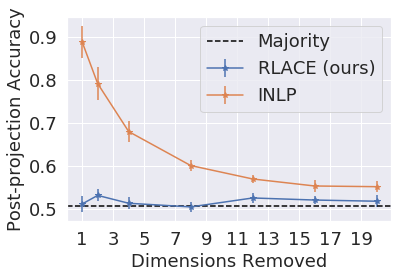

In [107]:
sn.set()

fig, ax = plt.subplots()
plt.rcParams['font.family'] = 'Sans'

df_rlace.plot('rank', 'average', yerr='std', ax=ax, label="RLACE (ours)", marker="*")
df_inlp.plot('rank', 'average', yerr='std', ax=ax, label="INLP", marker="*")
#df_pca.plot('rank', 'average', yerr='std', ax=ax, label="PCA-based", marker="*")
#v_measures_original_df.plot('num_clusters', 'average', yerr='std', ax=ax, label="Original space", marker="*", linestyle = "--")

plt.ylabel("Post-projection Accuracy", fontsize=18)
plt.xlabel("Dimensions Removed", fontsize=18)
ax.axhline(get_maj(y_test), label="Majority", color = "black", linestyle="--")

plt.legend(fontsize=18)
#ax.yaxis.grid(color='gray', linestyle="-")
#ax.xaxis.grid(color='gray', linestyle='-')
plt.yticks(fontsize=18)
plt.xticks(range(1,21,2), fontsize=18)
plt.subplots_adjust(bottom=0.17)
plt.subplots_adjust(left=0.15)
ax.figure.savefig("analysis/analysis-results/gender-glove.pdf", dpi = 700) 

plt.show()


In [80]:
y.mean()

0.5058503401360545

## load glove

In [267]:
#with open("glove-all-gendered_data.pickle", "rb") as f:
#    all_data = pickle.load(f)    
#vecs, words, labels = all_data["vecs"], all_data["words"], all_data["labels"]
model_all, vecs_all, words_all =  load_word_vectors(fname = "../../glove.42B.300d.txt")
rank=1

#vecs_cleaned = (P.dot(vecs_all.T)).T
#vecs_cleaned_inlp = (get_inlp_p(ws_inlp, rank)@vecs_all.T).T

"""
save_in_word2vec_format(vecs_cleaned, words_all, "../../glove.42B.300d.cleaned.rank={}.txt".format(rank))
save_in_word2vec_format(vecs_cleaned_inlp, words_all, "../../glove.42B.300d.cleaned-inlp.rank={}.txt".format(rank))


model_cleaned, _, _ = load_word_vectors(fname = "glove.42B.300d.cleaned.rank={}.txt".format(rank))
model_cleaned_inlp, _, _ = load_word_vectors(fname = "glove.42B.300d.cleaned-inlp.rank={}.txt".format(rank))
 """

import copy


In [270]:
def project_model(model, words, vecs, P):
    
    new = copy.deepcopy(model)
    
    vecs_proj = vecs@P
    for w,v in tqdm.tqdm_notebook(zip(words, vecs_proj)):
        new.__setitem__(w,v)
    
    return new

## WEAT

In [108]:
# Auxiliary functions for experiments by Caliskan et al.

import scipy
import scipy.misc as misc
import itertools

from sklearn.metrics.pairwise import cosine_similarity

def get_sim(vecs, w2ind, w1, w2):
    v1,v2 = vecs[w2ind[w1]], vecs[w2ind[w2]]
    sim = cosine_similarity([v1],[v2])[0]
    return sim
    

def s_word(w, A, B, vecs, w2ind, all_s_words):
    
    if w in all_s_words:
        return all_s_words[w]
    
    mean_a = []
    mean_b = []
    
    for a in A:
        mean_a.append(get_sim(vecs, w2ind, w, a))# model.similarity(w,a))
    for b in B:
        mean_b.append(get_sim(vecs, w2ind, w, b)) # model.similarity(w,b))
        
    mean_a = sum(mean_a)/float(len(mean_a))
    mean_b = sum(mean_b)/float(len(mean_b))
    
    all_s_words[w] = mean_a - mean_b

    return all_s_words[w]


def s_group(X, Y, A, B, vecs, w2ind, all_s_words):
    
    total = 0
    total_x, total_y = 0.,0.
    all_vals = []
    
    for x in X:
        x_sim = s_word(x, A, B, vecs, w2ind, all_s_words)
        total += x_sim
        total_x += x_sim
        all_vals.append(x_sim)
    for y in Y:
        y_sim =  s_word(y, A, B, vecs, w2ind, all_s_words)
        total -= y_sim
        total_y += y_sim
        all_vals.append(y_sim)
    
    #print(x_sim, y_sim)
    numerator = total_x/len(X) - total_y/len(Y)
    
    return total,numerator/np.std(all_vals)


def p_value_exhust(X, Y, A, B, vecs, w2ind):
    ["Ps"]
    if len(X) > 10:
        print ('might take too long, use sampled version: p_value')
        return
    
    assert(len(X) == len(Y))
    
    all_s_words = {}
    s_orig,d_statistic = s_group(X, Y, A, B, vecs, w2ind, all_s_words)
    #print("s-orig: {}".format(s_orig))
    
    union = set(X+Y)
    subset_size = int(len(union)/2)
    
    larger = 0
    total = 0
    #all_subs = set(itertools.combinations(union, subset_size))
    #print(all_subs)
    s_group_vals = []
    
    for subset in set(itertools.combinations(union, subset_size)):
        total += 1
        Xi = list(set(subset))
        Yi = list(union - set(subset))
        
        
        val,_ = s_group(Xi, Yi, A, B, vecs, w2ind, all_s_words)
        s_group_vals.append(val)
        
        if val > s_orig:
            larger += 1
    #print ('num of samples', total)
    
    return larger/float(total), d_statistic


def p_value_sample(X, Y, A, B, vecs, w2ind):
    
    random.seed(10)
    np.random.seed(10)
    all_s_words = {}
    
    assert(len(X) == len(Y))
    length = len(X)
    
    s_orig,_ = s_group(X, Y, A, B, vecs, w2ind, all_s_words) 
    
    num_of_samples = min(10000, int(scipy.special.comb(length*2,length)*100))
    print ('num of samples', num_of_samples)
    larger = 0
    for i in range(num_of_samples):
        permute = np.random.permutation(X+Y)
        Xi = permute[:length]
        Yi = permute[length:]
        if s_group(Xi, Yi, A, B, vecs, w2ind, all_s_words) > s_orig:
            larger += 1
    
    return larger/float(num_of_samples)

In [109]:
w2ind = {w:i for i,w in enumerate(words_all)}

In [111]:
# Experiment 1
vecs_cleaned_rlace = vecs_all @ projs_rlace[0][1]
vecs_cleaned_inlp = vecs_all @ projs_inlp[0][0]
vecs_cleaned_pca = vecs_all @ projs_words[0]
vecs_original = vecs_all

A = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']
B = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna']

C = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
D = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']

print ("Relaxed", p_value_exhust(A, B, C, D, vecs_cleaned_rlace, w2ind))
print ("INLP", p_value_exhust(A, B, C, D, vecs_cleaned_inlp, w2ind))
print ("PCA", p_value_exhust(A, B, C, D, vecs_cleaned_pca, w2ind))
print ("original", p_value_exhust(A, B, C, D, vecs_original, w2ind))

print("======================================================")

# Experiment 2

E = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
F = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']

print ("Relaxed", p_value_exhust(A, B, E, F, vecs_cleaned_rlace, w2ind))
print ("INLP", p_value_exhust(A, B, E, F, vecs_cleaned_inlp, w2ind))
print ("PCA", p_value_exhust(A, B, E, F, vecs_cleaned_pca, w2ind))
print ("original", p_value_exhust(A, B, E, F, vecs_original, w2ind))

print("======================================================")

# Experiment 3

G = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
H = ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']

print ("Relaxed", p_value_exhust(A, B, G, H, vecs_cleaned_rlace, w2ind))
print ("INLP", p_value_exhust(A, B, G, H, vecs_cleaned_inlp, w2ind))
print ("PCA", p_value_exhust(A, B, G, H, vecs_cleaned_pca, w2ind))
print ("original", p_value_exhust(A, B, G, H, vecs_original, w2ind))


Relaxed (0.07420357420357421, array([0.77301392]))
INLP (0.011732711732711733, array([1.08871693]))
PCA (0.005982905982905983, array([1.23937486]))
original (7.77000777000777e-05, array([1.694486], dtype=float32))
Relaxed (0.06045066045066045, array([0.80773742]))
INLP (0.03333333333333333, array([0.94080575]))
PCA (0.0024864024864024864, array([1.36596102]))
original (7.77000777000777e-05, array([1.5671507], dtype=float32))
Relaxed (0.06822066822066822, array([0.7797685]))
INLP (0.05485625485625486, array([0.8194422]))
PCA (0.010567210567210567, array([1.16131669]))
original (0.0001554001554001554, array([1.6302873], dtype=float32))


In [114]:
vecs_original = vecs_all  
weat = defaultdict(list)
weat_type2pair = {"profession-family": (C,D), "math-art": (E,F), "science-art": (G,H)}

for weat_type in ["profession-family", "math-art", "science-art"]:
    for method in ["PCA", "RLACE", "INLP"]:
    
        ps = []
        ds = []
        
        for seed in tqdm.tqdm_notebook(range(5)):
                
                vecs_cleaned_rlace = vecs_all @ projs_rlace[seed][1]
                vecs_cleaned_inlp = vecs_all @ projs_inlp[seed][0]
                vecs_cleaned_pca = vecs_all @ projs_words[0]
                method2vecs = {"PCA": vecs_cleaned_pca, "INLP": vecs_cleaned_inlp, "RLACE": vecs_cleaned_rlace}

                p,d = p_value_exhust(A, B, *weat_type2pair[weat_type], method2vecs[method], w2ind)
                d = d.item()
                ps.append(p)
                ds.append(d)
        mean_p, std_p = np.mean(ps), np.std(ps)
        mean_d, std_d = np.mean(ds), np.std(ds)
        d_str = "{:.2f} $\pm$ {:.2f}".format(mean_d, std_d)
        p_str = "{:.3f} $\pm$ {:.3f}".format(mean_p, std_p)
        weat[weat_type].append({"Method": method, "p": p_str, "d": d_str})

/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [115]:
p_orig,d_orig = p_value_exhust(A, B, C,D, vecs_all, w2ind)
d_orig=d_orig.item()

p_orig2,d_orig2 = p_value_exhust(A, B, E,F, vecs_all, w2ind)
d_orig2=d_orig2.item()

p_orig3,d_orig3 = p_value_exhust(A, B, G,H, vecs_all, w2ind)
d_orig3=d_orig3.item()


d_str = "{:.2f}".format(d_orig)
p_str = "{:.3f}".format(p_orig)
d_str2 = "{:.2f}".format(d_orig2)
p_str2 = "{:.3f}".format(p_orig2)
d_str3 = "{:.2f}".format(d_orig3)
p_str3 = "{:.3f}".format(p_orig3)

In [116]:
weat["profession-family"] = [{"Method": "Original", "d": d_str, "p": p_str}] + weat["profession-family"]
weat["math-art"] = [{"Method": "Original", "d": d_str2, "p": p_str2}] + weat["math-art"] 
weat["science-art"] = [{"Method": "Original", "d": d_str3, "p": p_str3}] + weat["science-art"] 

In [117]:
pd.DataFrame(weat["math-art"])

,Method,d,p
0,Original,1.57,0.000
1,PCA,1.37 $\pm$ 0.00,0.002 $\pm$ 0.000
2,RLACE,0.80 $\pm$ 0.01,0.062 $\pm$ 0.002
3,INLP,1.10 $\pm$ 0.10,0.016 $\pm$ 0.009


In [118]:
pd.DataFrame(weat["science-art"])

,Method,d,p
0,Original,1.63,0.000
1,PCA,1.16 $\pm$ 0.00,0.011 $\pm$ 0.000
2,RLACE,0.77 $\pm$ 0.01,0.073 $\pm$ 0.003
3,INLP,1.03 $\pm$ 0.11,0.022 $\pm$ 0.016


In [119]:
pd.DataFrame(weat["profession-family"])

,Method,d,p
0,Original,1.69,0.000
1,PCA,1.24 $\pm$ 0.00,0.006 $\pm$ 0.000
2,RLACE,0.78 $\pm$ 0.01,0.072 $\pm$ 0.003
3,INLP,1.15 $\pm$ 0.07,0.007 $\pm$ 0.003


In [120]:
with pd.option_context("max_colwidth", 1000):
    
    pd.DataFrame(weat["math-art"]).to_latex(buf="table-weat-math-art-rlace.latex", encoding='utf-8',escape=False,index=False)

In [121]:
with pd.option_context("max_colwidth", 1000):
    
    pd.DataFrame(weat["profession-family"]).to_latex(buf="table-weat-profession-family-rlace.latex", encoding='utf-8',escape=False,index=False)

In [122]:
with pd.option_context("max_colwidth", 1000):
    
    pd.DataFrame(weat["science-art"]).to_latex(buf="table-weat-science-art-rlace.latex", encoding='utf-8',escape=False,index=False)

## Smantic content

In [139]:
import pandas


def get_corr(vecs, w2ind):
    
    
    df = pandas.read_csv("glove_data/SimLex-999.txt", sep="\t")
    word1,word2,sim = df["word1"].tolist(), df["word2"].tolist(), df["SimLex999"].tolist()
    sim_pred = []
    sim = np.array(sim)

    has_w1 = [True if w in w2ind else False for w in word1]
    has_w2 = [True if w in w2ind else False for w in word2]
    has_w = np.array([True if (p and q) else False for p,q in zip(has_w1,has_w2)])


    ignored = []
    for w1,w2,s in zip(word1, word2, sim):
        if w1 not in w2ind or w2 not in w2ind: 
            #print("Skipping pair {}, {}".format(w1, w2))
            ignored.append(w1)
            ignored.append(w2)
            continue
        sim_pred.append(get_sim(vecs, w2ind, w1, w2))
        #sim_pred_relaxed.append(get_sim(vecs_cleaned_rlace, w2ind, w1, w2))
        #sim_pred_inlp.append(get_sim(vecs_cleaned_inlp, w2ind, w1, w2))

    sim = sim[has_w]
    return scipy.stats.pearsonr(sim,sim_pred)[0]
    #print("Correlation original: {}; Relaxed: {}; INLP: {}".format(scipy.stats.pearsonr(sim,sim_pred_orig), 
    #                                                           scipy.stats.pearsonr(sim,sim_pred_relaxed), 
    #                                                           scipy.stats.pearsonr(sim,sim_pred_inlp)))
    
    
originals = defaultdict(dict)
rlace = defaultdict(dict)
inlp = defaultdict(dict)
pca = defaultdict(dict)

for rand_seed in tqdm.tqdm_notebook(range(5)):    
    vecs_cleaned_rlace = vecs_all @ projs_rlace[rand_seed][1]
    vecs_cleaned_inlp = vecs_all @ projs_inlp[rand_seed][0]
    vecs_cleaned_pca = vecs_all @ projs_words[0]

    originals[0][0] = get_corr(vecs_all, w2ind)[0]
    
    for i,rank in enumerate(projs_rlace[rand_seed].keys()):
        vecs_cleaned_rlace = vecs_all @ projs_rlace[rand_seed][rank]
        print(rank)
        vecs_cleaned_inlp = vecs_all @ (projs_inlp[rand_seed][rank-1] )
        rlace[rand_seed][rank] = get_corr(vecs_cleaned_rlace, w2ind)[0]
        inlp[rand_seed][rank] = get_corr(vecs_cleaned_inlp, w2ind)[0]
        
    for rank in range(len(projs_words)):
        vecs_cleaned_pca = vecs_all @ projs_words[rank]
        pca[0][rank+1] = get_corr(vecs_cleaned_pca, w2ind)[0]
    


/home/nlp/ravfogs/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


1
2
4
8
12
16
20
1
2
4
8
12
16
20
1
2
4
8
12
16
20
1
2
4
8
12
16
20
1
2
4
8
12
16
20



In [140]:
# for k in originals:
#     for k2 in originals[k]:
#         originals[k][k2] = originals[k][k2].item()
# for k in rlace:
#     for k2 in rlace[k]:
#         rlace[k][k2] = rlace[k][k2].item()
# for k in inlp:
#     for k2 in inlp[k]:
#         inlp[k][k2] = inlp[k][k2].item()
# for k in pca:
#     for k2 in pca[k]:
#         pca[k][k2] = pca[k][k2].item()
        
df_originals = pd.DataFrame(originals)
df_rlace = pd.DataFrame(rlace)
df_inlp = pd.DataFrame(inlp)
df_pca = pd.DataFrame(pca)

for df in [df_originals, df_rlace, df_inlp, df_pca]:
    
    df['average'] = df.mean(numeric_only=True, axis=1)
    df["std"] = df.std(numeric_only=True, axis=1)
    df.rename_axis("Rank", inplace=True)
    df.reset_index(inplace=True)

In [141]:
df_inlp

,Rank,0,1,2,3,4,average,std
0,1,0.394646,0.395354,0.395164,0.395119,0.395427,0.395142,0.000273
1,2,0.394551,0.396678,0.395174,0.394141,0.394080,0.394925,0.000959
2,4,0.392764,0.397447,0.395771,0.392791,0.392831,0.394321,0.001942
3,8,0.391651,0.394828,0.395624,0.390421,0.389623,0.392429,0.002387
4,12,0.386403,0.393794,0.393503,0.388746,0.388302,0.390150,0.002965
5,16,0.389442,0.390877,0.391766,0.388672,0.390344,0.390220,0.001081
6,20,0.396127,0.389760,0.393424,0.392856,0.393180,0.393070,0.002024


In [142]:
df_rlace

,Rank,0,1,2,3,4,average,std
0,1,0.392260,0.392466,0.392354,0.392393,0.392290,0.392353,0.000074
1,2,0.392309,0.392468,0.392738,0.393184,0.391761,0.392492,0.000471
2,4,0.389404,0.391196,0.391726,0.391849,0.393374,0.391510,0.001278
3,8,0.390623,0.392150,0.392385,0.392497,0.391311,0.391793,0.000718
4,12,0.391522,0.394520,0.390108,0.389775,0.388597,0.390904,0.002034
5,16,0.396603,0.391596,0.387501,0.393288,0.391805,0.392159,0.002938
6,20,0.390144,0.385910,0.390436,0.390817,0.391207,0.389703,0.001930


In [143]:
df_pca

,Rank,0,average,std
0,1,0.168936,0.168936,0.0
1,2,0.340804,0.340804,0.0
2,3,0.319348,0.319348,0.0
3,4,0.384118,0.384118,0.0
4,5,0.395134,0.395134,0.0
5,6,0.386605,0.386605,0.0
6,7,0.396802,0.396802,0.0
7,8,0.387988,0.387988,0.0
8,9,0.404865,0.404865,0.0
9,10,0.409585,0.409585,0.0


In [144]:
df_originals

,Rank,0,average,std
0,0,0.399052,0.399052,0.0


In [145]:
common_vecs, common_ws = vecs_all[:15000], words_all[:15000]
common_vecs_transformed =  common_vecs@projs_rlace[0][1]

In [146]:
sims_original = cosine_similarity(common_vecs,common_vecs)
sims_transformed = cosine_similarity(common_vecs_transformed,common_vecs_transformed)
sims_transformed = sims_transformed.argsort(axis=1)
sims_original = sims_original.argsort(axis=1)

words = []

for i in range(15):
    j = np.random.choice(range(5000))
    w = common_ws[j]
    before = [common_ws[k] for k in sims_original[j][-4:-1]]
    after = [common_ws[k] for k in sims_transformed[j][-4:-1]]
    print(w, before, after)
    words.append({"Word": w, "Neighbors before": ", ".join(before), "Neighbors after": ", ".join(after)})

history ['literature', 'histories', 'historical'] ['literature', 'histories', 'historical']
1989 ['1991', '1987', '1988'] ['1991', '1987', '1988']
afternoon ['saturday', 'evening', 'morning'] ['sunday', 'evening', 'morning']
consumers ['buyers', 'customers', 'consumer'] ['buyers', 'customers', 'consumer']
allowed ['allowing', 'allow', 'permitted'] ['allowing', 'allow', 'permitted']
leg ['thigh', 'knee', 'legs'] ['thigh', 'knee', 'legs']
manner ['therefore', 'regard', 'thus'] ['means', 'regard', 'thus']
vinyl ['metal', 'lp', 'pvc'] ['metal', 'lp', 'pvc']
injury ['injured', 'accident', 'injuries'] ['injured', 'accident', 'injuries']
worried ['afraid', 'concerned', 'worry'] ['afraid', 'concerned', 'worry']
dishes ['cooking', 'cuisine', 'dish'] ['meals', 'cuisine', 'dish']
thursday ['monday', 'tuesday', 'wednesday'] ['monday', 'tuesday', 'wednesday']
sisters ['brothers', 'daughters', 'sister'] ['daughters', 'brothers', 'sister']
wants ['decides', 'thinks', 'knows'] ['decides', 'thinks', 'k

In [154]:
df = pd.DataFrame(words)
with pd.option_context("max_colwidth", 1000):
    
    df.to_latex(buf="table-neighbors-rlace.latex", encoding='utf-8',escape=False,index=False)

In [137]:

words = []

word_set = ["lucy", "john", "mary", "michael", "edith", "jonathan", "daniel", "ann", "anna", "olivia", "james", "sophia"]

female_names = ["lucy", "mary", "edith", "ann", "olivia", "ann", "alice", "sophia", "emma", "naomi", "claire", "gabriella",
               "clara", "jennifer", "judy", "angelina", "helen"]
male_names = ["john", "michael", "jonathan", "daniel", "james", "samuel"]




for w in ["lawyer"]: #female_names + male_names:
    j = words_all.index(w)
    if j >= len(common_vecs): continue
    before = [words_all[k] for k in sims_original[j][-6:-1]]
    after = [words_all[k] for k in sims_transformed[j][-6:-1]]
    print(w, before, after)
    words.append({"Word": w, "Neighbors before": ", ".join(before), "Neighbors after": ", ".join(after)})

lawyer ['malpractice', 'litigation', 'attorneys', 'lawyers', 'attorney'] ['litigation', 'malpractice', 'attorneys', 'lawyers', 'attorney']


In [517]:
X.shape[0], X_dev.shape[0], X_test.shape[0]

(7350, 3150, 4500)